In [1]:
from qiskit import *
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
depth = 3
rep = 1000

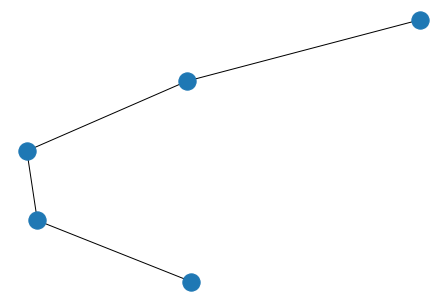

In [3]:
#defining the graph, to simulate another graph simply change the Nodes and Edges
G=nx.Graph()
Nodes=[0,1,2,3,4]     
Edges=[(0,1,1.0),(1,2,1.0),(2,3,1.0),(3,4,1.0)]   # Edges with theirs weights
G.add_nodes_from(Nodes)
G.add_weighted_edges_from(Edges)
nx.draw(G)

In [4]:
# this functions returns the cost unitary gate. More about this can be found in the other document in the repository.  
def get_costunitary(gamma):
    HC=QuantumCircuit(len(Nodes))
    
    for e in Edges:
        
        HC.cp(-2*gamma*e[2],e[0],e[1])
        HC.p(gamma*e[2],e[0])
        HC.p(gamma*e[2],e[1])
        
    CU = HC.to_gate()                                                      # converts HU circuit to gate
    
    return CU

In [5]:
# this functions returns the mixer unitary gate. More about this can be found in the other document in the repository.  
def get_mixerunitary(beta):
    
    HC=QuantumCircuit(len(Nodes))
    HC.rx(2*beta,range(len(Nodes)))
    
    MU=HC.to_gate()
    
    return MU

In [6]:
# creates the circuit and runs it, then returns the measured bits as a list of list of integers like [[1,0,1,1,1],[0,0,1,1,0],[...]]
def create_circuit(params):
    
    gamma = [params[0], params[2], params[4], params[6]]
    beta = [params[1], params[3], params[5], params[7]]
    
    HC=QuantumCircuit(len(Nodes), len(Nodes))
    
    for i in range(len(Nodes)):
        HC.h(i)
        
    for i in range (depth):
        HC.append(get_costunitary(gamma[i]),list(range(len(Nodes))))
        HC.append(get_mixerunitary(beta[i]),list(range(len(Nodes))))
        
    HC.measure(range(len(Nodes)), range(len(Nodes)))
    
    simulate = execute(HC, backend = Aer.get_backend('qasm_simulator'), shots = rep)
    HC_results = simulate.result().get_counts()
    
    return HC_results
        
        
    
    

In [7]:
def cost_function(params):
    
    av = create_circuit(params)
    bv = list(av)                                                   
    total_cost = 0
    for bitstring in bv:                          
        S=list(bitstring)
        S=list(map(int,S))                                   #converting the string of measured bits into list of integers to use in computation
        
        for E in Edges:
            total_cost += 0.5*E[2]*av[bitstring]*( ( (1 - 2*S[E[0]]) * (1 - 2*S[E[1]]) ) - 1)
            
    total_cost = float(total_cost)/rep

    return total_cost

In [8]:
import random

In [9]:
from qiskit.visualization import plot_histogram

In [10]:
init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})
print(out)

     fun: -3.561
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 85
  status: 1
 success: True
       x: array([-2.28726482, -0.21797756,  1.58217701, -2.60559168, -1.45204607,
       -1.31490001, -1.58719632, -0.80799276])


In [11]:
out

     fun: -3.561
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 85
  status: 1
 success: True
       x: array([-2.28726482, -0.21797756,  1.58217701, -2.60559168, -1.45204607,
       -1.31490001, -1.58719632, -0.80799276])

In [12]:
n = create_circuit(getattr(out,'x'))

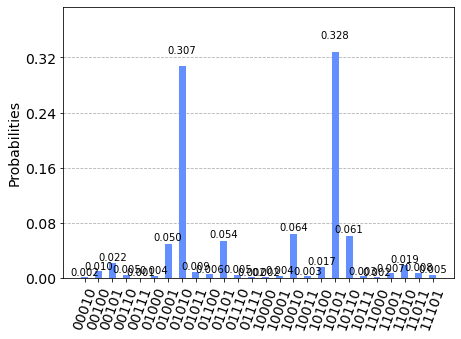

In [13]:
plot_histogram(n)

In [14]:
# We can see above the two values of bit strings where the probabilities are the highest, the fact that the distribution is symmetric makes sense since we simulated a linear graph with the same weights.